# Modeling Stock Returns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
psei = pd.read_csv('Data2.csv', index_col=1, parse_dates=True)
psei = psei.iloc[:, 1:-1]
psei.head()

,Open,High,Low,Close
Date/Time,,,,
1958-01-31,3.06,3.06,3.06,3.06
1958-02-28,2.92,2.92,2.92,2.92
1958-03-31,3.15,3.15,3.15,3.15
1958-04-30,3.45,3.45,3.45,3.45
1958-05-31,3.56,3.56,3.56,3.56


In [4]:
psei['LogReturn'] = np.log(psei['Close']).shift(-1) - np.log(psei['Close'])
psei.head()

,Open,High,Low,Close,LogReturn
Date/Time,,,,,
1958-01-31,3.06,3.06,3.06,3.06,-0.046831
1958-02-28,2.92,2.92,2.92,2.92,0.075819
1958-03-31,3.15,3.15,3.15,3.15,0.090972
1958-04-30,3.45,3.45,3.45,3.45,0.031386
1958-05-31,3.56,3.56,3.56,3.56,0.211844


In [5]:
psei_2014 = psei['2014-01-01':]
psei_2014.head()

,Open,High,Low,Close,LogReturn
Date/Time,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,-0.006089
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,0.006348
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,-0.006431
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,0.006543
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,-0.008214


In [6]:
mu = psei_2014['LogReturn'].mean()
sigma = psei_2014['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(psei_2014['LogReturn'].min() - 0.01,
                        psei_2014['LogReturn'].max() + 0.01,
                        0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

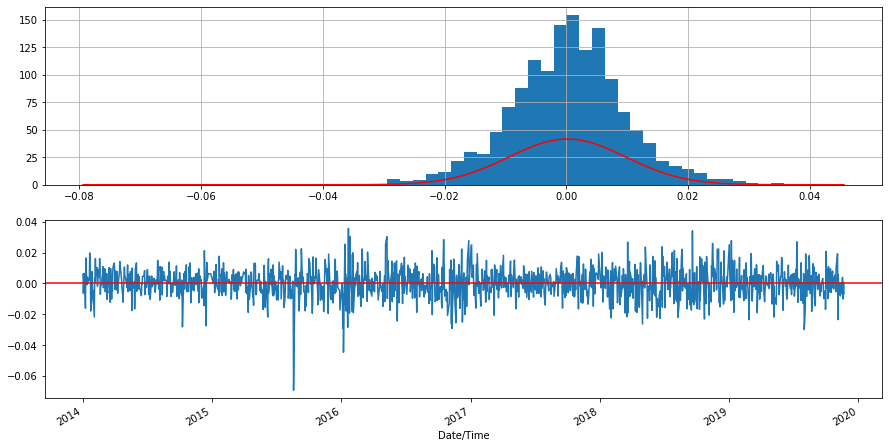

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

psei_2014['LogReturn'].hist(bins=50, ax = ax[0])
ax[0].plot(density['x'], density['pdf'], color='red');

psei_2014['LogReturn'].plot(ax=ax[1])
ax[1].axhline(0, color='red');

# Compute probs

In [8]:
print(f'Probability of a 5% drop: {norm.cdf(-0.05, mu, sigma)}')
print(f'Probability of a 10% drop: {norm.cdf(-0.1, mu, sigma)}')

Probability of a 5% drop: 8.709918109547475e-08
Probability of a 10% drop: 8.956099236108118e-26


In [9]:
year_mu = mu * 220
year_sigma = sigma * np.sqrt(220)
print(f'Probability of a 20% drop in a year: {norm.cdf(-0.2, year_mu, year_sigma)}')
print(f'Probability of a 40% drop in a year: {norm.cdf(-0.4, year_mu, year_sigma)}')

Probability of a 20% drop in a year: 0.045955339771050506
Probability of a 40% drop in a year: 0.0010029687799430087


# VAR

In [10]:
print(f'Single day 5% VAR: {norm.ppf(0.05, mu, sigma)}')
print(f'95% quantile: {norm.ppf(0.95, mu, sigma)}')

Single day 5% VAR: -0.015615488387171013
95% quantile: 0.01597998768175726


In [11]:
print(f'25% quantile: {norm.ppf(0.25, mu, sigma)}')
print(f'75% quantile: {norm.ppf(0.75, mu, sigma)}')

25% quantile: -0.006295781106286636
75% quantile: 0.00666028040087289


# Hypothesis Testing

In [12]:
n = psei_2014.shape[0]
std_error = sigma / np.sqrt(n)

z_left = norm.ppf(0.05)
z_right = norm.ppf(0.95)

left_interval = mu + z_left * std_error
right_interval = mu + z_right * std_error

print(f'90% confidence interval of avg returns: {left_interval, right_interval}')

90% confidence interval of avg returns: (-0.00023478194603003509, 0.0005992812406162882)


# Test Statistic

In [13]:
zhat = (mu - 0) / (std_error)
zhat

0.718828017253907

In [14]:
alpha = 0.05

zleft = norm.ppf(alpha/2)
zright = -zleft

print(f'Two tailed: {zleft, zright}')
print(f'At {alpha} signifance level, reject null: {zhat > zright}')

Two tailed: (-1.9599639845400545, 1.9599639845400545)
At 0.05 signifance level, reject null: False


In [15]:
zright = norm.ppf(1-alpha)

print(f'One tail: {zright}')
print(f'At {alpha} signifance level, reject null: {zhat > zright}')

One tail: 1.6448536269514722
At 0.05 signifance level, reject null: False


# P Value

In [16]:
p = 1 - norm.cdf(zhat)

print(f'p value: {p}')
print(f'At {alpha} significance level, reject null: {p < alpha}')

p value: 0.23612344633002535
At 0.05 significance level, reject null: False


# Linear Regression

In [17]:
psei_2014['Y'] = psei_2014['Close'].shift(-1) - psei_2014['Close']
psei_2014.head()

,Open,High,Low,Close,LogReturn,Y
Date/Time,,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,-0.006089,-36.3296
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,0.006348,37.8799
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,-0.006431,-38.3702
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,0.006543,39.0401
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,-0.008214,-48.9702


In [18]:
for i in range(9):
    psei_2014['X' + str(i)] = np.log(psei_2014['Close'].shift(i)) - np.log(psei_2014['Close'].shift(i+1))
psei_2014.head()

,Open,High,Low,Close,LogReturn,Y,X0,X1,X2,X3,X4,X5,X6,X7,X8
Date/Time,,,,,,,,,,,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,-0.006089,-36.3296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,0.006348,37.8799,-0.006089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,-0.006431,-38.3702,0.006348,-0.006089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,0.006543,39.0401,-0.006431,0.006348,-0.006089,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,-0.008214,-48.9702,0.006543,-0.006431,0.006348,-0.006089,NaN,NaN,NaN,NaN,NaN


In [19]:
psei_2014.dropna(inplace=True)
psei_2014.head(10)

,Open,High,Low,Close,LogReturn,Y,X0,X1,X2,X3,X4,X5,X6,X7,X8
Date/Time,,,,,,,,,,,,,,,
2014-01-15,5938.3301,5969.1602,5938.3301,5958.1201,0.004040,24.1201,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543,-0.006431,0.006348,-0.006089
2014-01-16,5977.9600,5999.5801,5972.3901,5982.2402,0.000810,4.8496,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543,-0.006431,0.006348
2014-01-17,5993.0898,6008.2202,5960.9800,5987.0898,0.003087,18.5103,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543,-0.006431
2014-01-20,5988.3901,6019.7500,5988.3901,6005.6001,0.002269,13.6401,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543
2014-01-21,6006.5898,6030.9702,5983.8901,6019.2402,0.019841,120.6197,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214
2014-01-22,6020.3999,6147.1802,6020.3999,6139.8599,0.004905,30.1899,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066
2014-01-23,6145.1602,6180.7300,6139.7402,6170.0498,0.003470,21.4502,0.004905,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598
2014-01-24,6166.5801,6195.6401,6095.5898,6191.5000,-0.017908,-109.8901,0.003470,0.004905,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861
2014-01-27,6185.5801,6185.5801,6035.9800,6081.6099,-0.009716,-58.7998,-0.017908,0.003470,0.004905,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794


In [20]:
train_size = 0.8
train_idx = int(len(psei_2014) * train_size)

train = psei_2014.iloc[:train_idx, :]
test = psei_2014.iloc[train_idx:, :]

print(train.shape, test.shape)

(1140, 15) (285, 15)


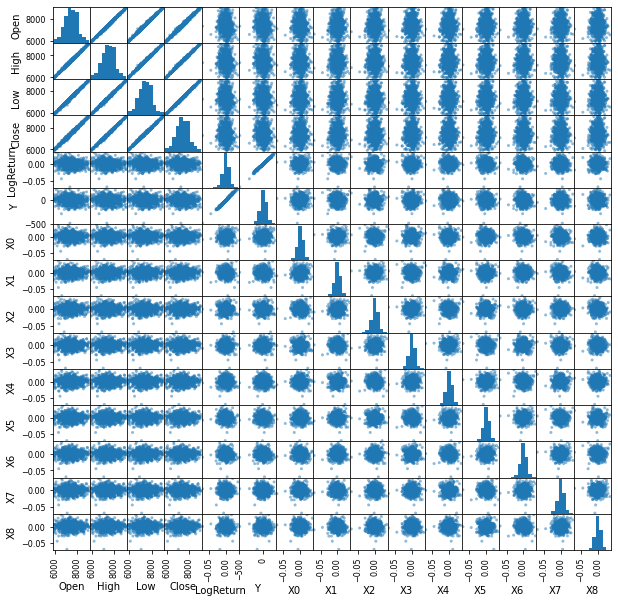

In [21]:
sm = scatter_matrix(train, figsize=(10, 10))

In [22]:
train.corr()['Y']

Open        -0.085165
High        -0.081113
Low         -0.083199
Close       -0.083507
LogReturn    0.996638
Y            1.000000
X0           0.026754
X1          -0.038117
X2          -0.011470
X3          -0.002843
X4          -0.017969
X5          -0.066600
X6          -0.033246
X7           0.009890
X8          -0.036113
Name: Y, dtype: float64

In [23]:
formula = 'Y~X0+X1+X2+X3+X4+X5+X6+X7+X8'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.228
Date:                Thu, 23 Sep 2021   Prob (F-statistic):              0.274
Time:                        09:39:35   Log-Likelihood:                -6459.0
No. Observations:                1140   AIC:                         1.294e+04
Df Residuals:                    1130   BIC:                         1.299e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5500      2.083      0.744      0.457      -2.537       5.637
X0           181.6093    218.171      0.832      0.405    -246.457     609.675
X1          -296.8817    219.468     -1.353      0.176    -727.493     133.730
X2           -98.0034    219.476     -0.447      0.655    -528.629     332.622
X3           -43.6094    218.727     -0.199      0.842    -472.767     385.548
X4          -135.2016    219.013     -0.617      0.537    -564.920     294.517
X5          -482.1181    218.970     -2.202      0.028    -911.751     -52.485
X6          -243.6020    219.605     -1.109      0.268    -674.482     187.278
X7            53.5106    219.619      0.244      0.808    -377.397     484.418
X8          -300.4778    219.620     -1.368      0.172    -731.387     130.431
==============================================================================
Omnibus:                      111.024   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.557
Skew:                          -0.450   Prob(JB):                     5.65e-81
Kurtosis:                       5.640   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
train['y_hat'] = lm.predict(train)
test['y_hat'] = lm.predict(test)

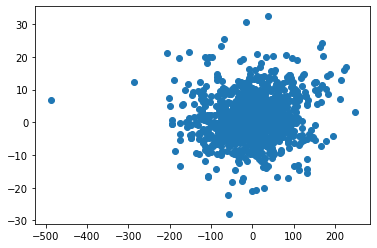

In [25]:
plt.scatter(train['Y'], train['y_hat'])

# Trading the predictions

In [26]:
class equity:
    def __init__(self, df):
        self.df = df
        self.equity_df = pd.DataFrame()
        self.equity_df['order'] = [1 if sig > 0 else 0 for sig in self.df['y_hat']]
        self.equity_df['profit'] = self.df['Y'].values * self.equity_df['order']
        self.equity_df['wealth'] = self.equity_df['profit'].cumsum()
        
    def plot_curve(self):
        plt.figure(figsize=(10, 10))
        plt.plot(self.equity_df['wealth'].values, color='green', label='Signal Based')
        plt.plot(self.df['Y'].cumsum().values, color='red', label='Buy and Hold')
        plt.legend()
        plt.plot()
        print(f"Signal based profit: {round(self.equity_df['profit'].sum(),2)}")
        print(f"Buy and hold based profit: {round(self.df['Y'].sum(),2)}")
        
    def evaluate(self):
        equity_copy = self.equity_df.copy()
        equity_copy['wealth'] = equity_copy['wealth'] + self.df['Close'][0]
        equity_copy['return'] = np.log(equity_copy['wealth']) - np.log(equity_copy['wealth'].shift(1))
        dailyr = equity_copy['return'].dropna()
        equity_copy['peak'] = equity_copy['wealth'].cummax()
        equity_copy['drawdown'] = (equity_copy['peak'] - equity_copy['wealth']) / equity_copy['peak']
        print(f'Daily sharpe ratio: {dailyr.mean() / dailyr.std(ddof=1)}')
        print(f'Yearly sharpe ratio: {dailyr.mean() / dailyr.std(ddof=1) * np.sqrt(252)}')
        print(f"Max drawdown: {equity_copy['drawdown'].max()}")

Signal based profit: 4102.21
Buy and hold based profit: 1475.49


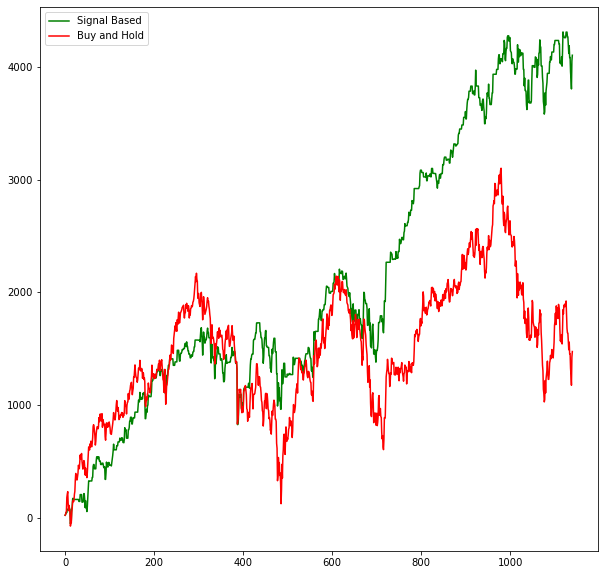

In [27]:
training_set_hist = equity(train)
training_set_hist.plot_curve()

In [28]:
training_set_hist.evaluate()

Daily sharpe ratio: 0.06576333153017318
Yearly sharpe ratio: 1.0439605236955862
Max drawdown: 0.1123406647830367


Signal based profit: 405.32
Buy and hold based profit: 338.01


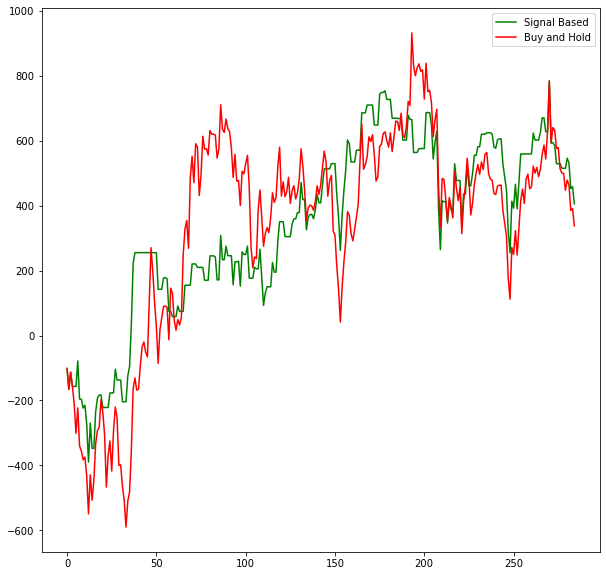

In [29]:
testing_set_hist = equity(test)
testing_set_hist.plot_curve()

In [30]:
testing_set_hist.evaluate()

Daily sharpe ratio: 0.03361485732797134
Yearly sharpe ratio: 0.533619317080376
Max drawdown: 0.060939810015206826


# Experimenting with Machine Learning

In [65]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [66]:
feats = [i for i in train.columns.values if 'X' in i]
X_train = train[feats]
y_train = train['Y']
X_test = test[feats]
y_test = test['Y']

In [67]:
def fit_mod(mod):
    mod = mod()
    mod.fit(X_train, y_train)
    train_preds = mod.predict(X_train)
    test_preds = mod.predict(X_test)
    return train_preds, test_preds

## SVR

Signal based profit: 2244.71
Buy and hold based profit: 1475.49


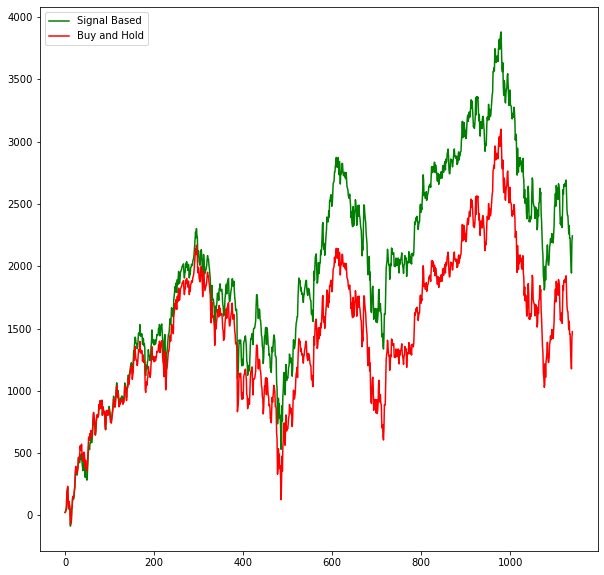

In [81]:
train['y_hat'], test['y_hat'] = fit_mod(SVR)
train_history = equity(train)
test_history = equity(test)
train_history.plot_curve()

In [82]:
train_history.evaluate()

Daily sharpe ratio: 0.031097905989043644
Yearly sharpe ratio: 0.4936639532512537
Max drawdown: 0.2145325466993328


Signal based profit: 525.63
Buy and hold based profit: 338.01


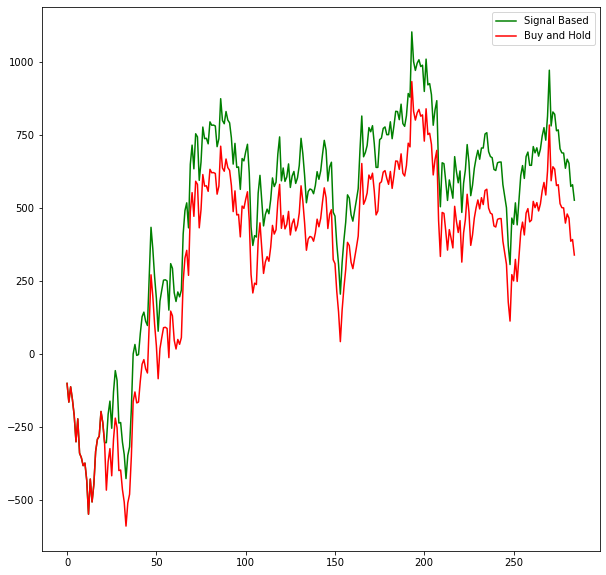

In [83]:
test_history = equity(test)
test_history.plot_curve()

In [84]:
test_history.evaluate()

Daily sharpe ratio: 0.030575879618285777
Yearly sharpe ratio: 0.48537704152219613
Max drawdown: 0.09329100797539375


## KNN

Signal based profit: 15154.6
Buy and hold based profit: 1475.49


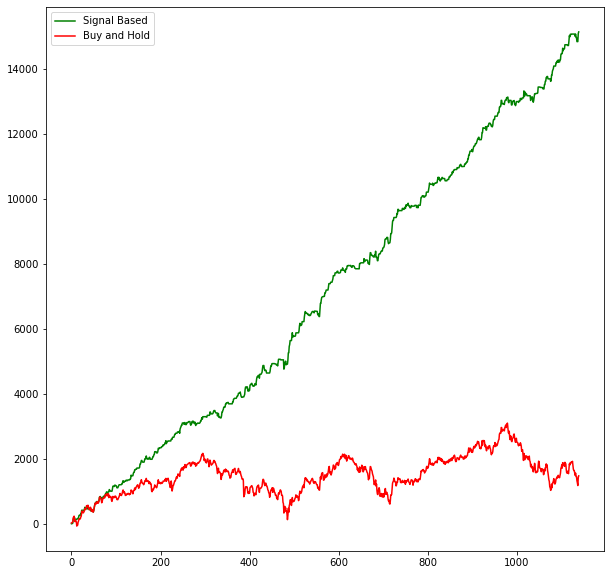

In [85]:
train['y_hat'], test['y_hat'] = fit_mod(KNeighborsRegressor)
train_history = equity(train)
test_history = equity(test)
train_history.plot_curve()

In [86]:
train_history.evaluate()

Daily sharpe ratio: 0.2746904586214305
Yearly sharpe ratio: 4.3605758462075
Max drawdown: 0.027595872130218267


Signal based profit: 1219.79
Buy and hold based profit: 338.01


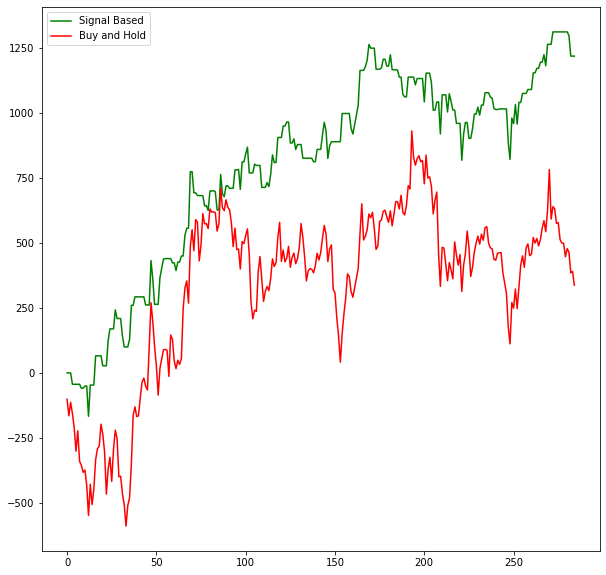

In [87]:
test_history.plot_curve()

In [88]:
test_history.evaluate()

Daily sharpe ratio: 0.09225163066911568
Yearly sharpe ratio: 1.4644492367439552
Max drawdown: 0.05128123976765596


## RFR

Signal based profit: 30623.72
Buy and hold based profit: 1475.49


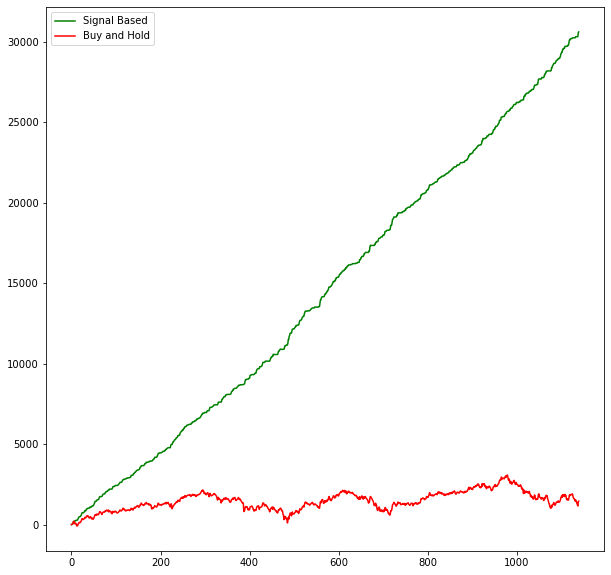

In [89]:
train['y_hat'], test['y_hat'] = fit_mod(RandomForestRegressor)
train_history = equity(train)
test_history = equity(test)
train_history.plot_curve()

In [90]:
train_history.evaluate()

Daily sharpe ratio: 0.6236693392919149
Yearly sharpe ratio: 9.900443832614226
Max drawdown: 0.0018874090435642475


Signal based profit: -95.0
Buy and hold based profit: 338.01


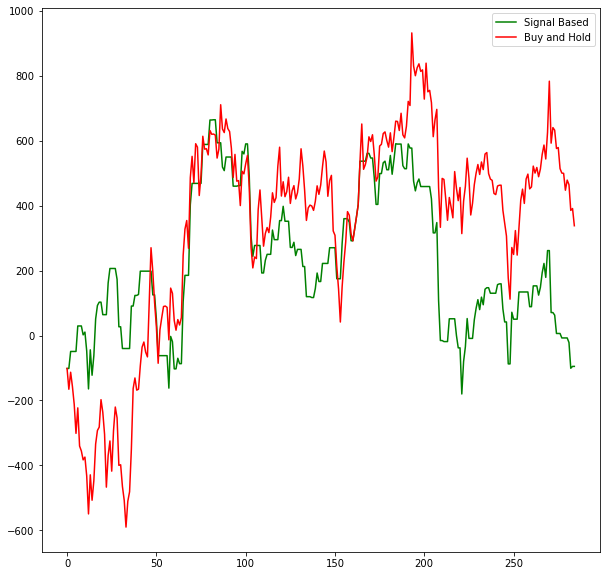

In [91]:
test_history.plot_curve()

In [92]:
test_history.evaluate()

Daily sharpe ratio: 0.0004356543707796295
Yearly sharpe ratio: 0.006915798735967344
Max drawdown: 0.10425927644480769


## LGBM

Signal based profit: 30083.1
Buy and hold based profit: 1475.49


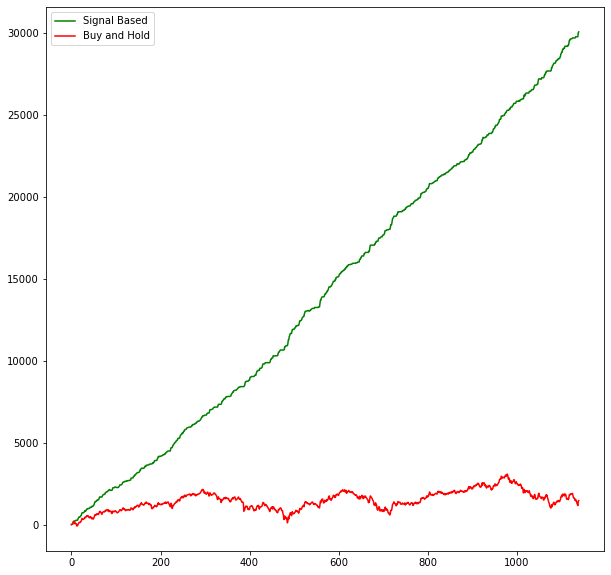

In [93]:
train['y_hat'], test['y_hat'] = fit_mod(LGBMRegressor)
train_history = equity(train)
test_history = equity(test)
train_history.plot_curve()

In [94]:
train_history.evaluate()

Daily sharpe ratio: 0.6038766397995518
Yearly sharpe ratio: 9.586244468825662
Max drawdown: 0.006197966093878858


Signal based profit: 737.94
Buy and hold based profit: 338.01


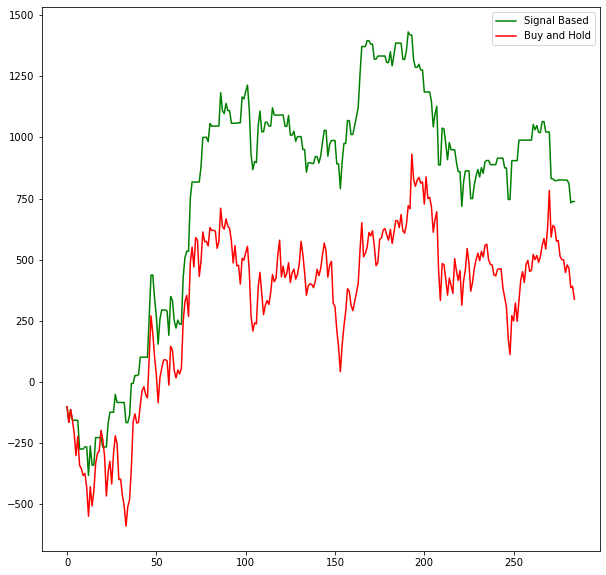

In [95]:
test_history.plot_curve()

In [96]:
test_history.evaluate()

Daily sharpe ratio: 0.05292404787072188
Yearly sharpe ratio: 0.8401432142448454
Max drawdown: 0.08049399170122427
